# Mean Reversion Trading Strategy
by Chee-Foong on 15 Apr 2021

**Summary**  
This analysis creates a portfolio of assets that is cointegrated and mean reverting.  Using a linear mean reverting trading strategy on the portfolio, we assess its performance and risk analytics.

Cryptocurrenies are trading assets used in this analysis.  Namely, Bitcoin, Ethereum and Litcoin.

**Reference**
1. https://letianzj.github.io/cointegration-pairs-trading.html
2. https://blog.quantinsti.com/johansen-test-cointegration-building-stationary-portfolio/?utm_campaign=News&utm_medium=Community&utm_source=DataCamp.com
3. https://www.statsmodels.org/dev/generated/statsmodels.tsa.vector_ar.vecm.coint_johansen.html
4. https://flare9xblog.wordpress.com/2017/09/27/half-life-of-mean-reversion-ornstein-uhlenbeck-formula-for-mean-reverting-process/#:~:text=Mean%20reverting%20series%20exhibit%20negative,%E2%88%92log(2)%2F%CE%BB%20.
5. https://quant.stackexchange.com/questions/2076/how-to-interpret-the-eigenmatrix-from-a-johansen-cointegration-test
6. https://pythonforfinance.net/2016/07/10/python-backtesting-mean-reversion-part-4/#more-15487
7. https://medium.com/bluekiri/cointegration-tests-on-time-series-88702ea9c492
8. https://medium.com/bluekiri/simple-stationarity-tests-on-time-series-ad227e2e6d48

## Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# IMPORTS
import pandas as pd
import numpy as np

import time
import math
import os.path

# from tqdm import tnrange, notebook
from tqdm.notebook import tqdm

from datetime import timedelta, datetime
from dateutil import parser

# Import the plotting library
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.dates import MonthLocator

import seaborn as sns
sns.set()

In [2]:
import sys  
sys.path.append('../src') 

from edge_mean_reversion import *
from edge_binance import *
from edge import *

from edge_risk_kit import *
import edge_risk_kit as erk

## Import Data

Cryptocurrency prices data are downloaded from Binance using their API.   The prices are preprocessed, resampled into daily points and stored as HDFStore format for quick retrieval.

In [3]:
prices = load_from_HDFStore(DATA_FOLDER + 'crypto.h5', 'crypto')
prices

,eth,btc,ltc
timestamp,,,
2017-08-17 08:00:00+08:00,302.00,4285.08,NaN
2017-08-18 08:00:00+08:00,293.96,4108.37,NaN
2017-08-19 08:00:00+08:00,290.91,4139.98,NaN
2017-08-20 08:00:00+08:00,299.10,4086.29,NaN
2017-08-21 08:00:00+08:00,323.29,4016.00,NaN
...,...,...,...
2021-04-11 08:00:00+08:00,2151.36,60002.43,252.31
2021-04-12 08:00:00+08:00,2137.69,59860.00,244.42
2021-04-13 08:00:00+08:00,2299.19,63575.00,267.59


## Data Preprocessing

Selecting prices on and beyond 2020 for this analysis.

In [4]:
prices.dropna(inplace=True)
prices = prices['2020':]

In [5]:
PERIOD_PER_YEAR = 252 * 1
PERIOD_PER_DAY = 1

## Exploratory Data Analysis

A quick look at the data

### Price Plots

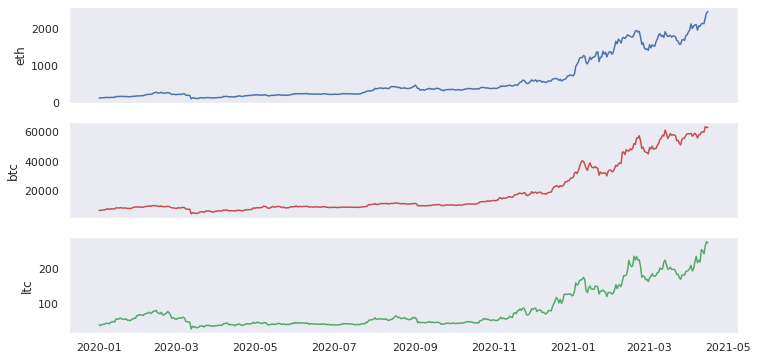

In [6]:
def draw_pair_plot(data, figsize=(10,6)):

    ts1 = data.iloc[:,0]
    ts2 = data.iloc[:,1]
    ts3 = data.iloc[:,2]
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=figsize)

    ax1.plot(ts1.index, ts1.values, label = ts1.name)
    ax2.plot(ts2.index, ts2.values, label = ts2.name, color = 'r')
    ax3.plot(ts3.index, ts3.values, label = ts3.name, color = 'g')

    ax1.set_ylabel(ts1.name)
    ax2.set_ylabel(ts2.name)
    ax3.set_ylabel(ts3.name)
    
    ax1.grid()
    ax2.grid()
    ax3.grid()

    plt.show()
    
draw_pair_plot(prices[['eth','btc','ltc']], figsize=(12,6))    

### Correlations of Returns

In [7]:
returns = prices.pct_change().dropna()
returns.corr()

,eth,btc,ltc
eth,1.000000,0.802716,0.817809
btc,0.802716,1.000000,0.800931
ltc,0.817809,0.800931,1.000000


### Pair Plots of Returns

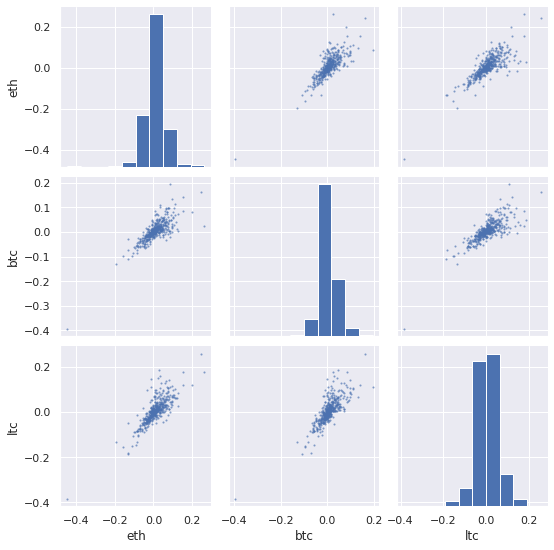

In [8]:
sns.pairplot(data=returns, plot_kws = {'alpha': 0.5, 's': 2, 'edgecolor': 'b'})
plt.show()

## Mean Reversion Test
Conducting mean reversion test on each cryptocurrencies to assess whether they possess any mean reversion properties individually.

### Augmented Dickey Fuller Test
Test whether a time series is stationary.  Stationary means the mean and standard deviation do not change over time.  Returns tuples of ADF Statistics, p-value and True if series is stationary.

In [9]:
# from arch.unitroot import ADF
# print(ADF(prices.btc).summary().as_text())

Based on augmented dickey fuller test, none of the currencies are stationary.

In [10]:
prices.apply(lambda x: perform_adf_test(x), axis=0)

,eth,btc,ltc
0,2.529119,2.684779,1.799109
1,0.999059,0.999086,0.998347
2,False,False,False


### Hurst Exponent

- Random Walk has a hurst exponent, H = 0.5 
- Mean Reversion has a hurst exponent, H < 0.5 
- Trending has a hurst exponent, H > 0.5 
- Returns tuples of the Hurst Exponent and whether the Time Series is mean reverting.

Litcoin is slightly mean reverting while the rest is trending.

In [11]:
prices.apply(lambda x: perform_hurst_exp_test(x), axis=0)

,eth,btc,ltc
0,0.540933,0.580285,0.437245
1,False,False,True


### Variance Ratio

The null hypothesis of a VR is that the process is a random walk, possibly plus drift.  Rejection of the null with a positive test statistic indicates the presence of positive serial correlation in the time series.

Return p-value. Less than 0.05, reject null hypothesis. It is not a random walk if True.

We cannot confirm that the cryptocurrencies are not a random walk.

In [12]:
prices.apply(lambda x: perform_variance_ratio_test(x), axis=0)

,eth,btc,ltc
0,0.509812,0.70597,0.974984
1,False,False,False


### Half-Life
How long does it take for a time series to mean revert. 

Since the halflife of the cryptocurrencies are all negative, their betas are positive: returns at t is positively correlated with the price at t-1, and therefore their price series are not mean reverting.

In [13]:
prices.apply(lambda x: round(half_life_v2(x)/PERIOD_PER_DAY), axis=0)

eth    -91
btc   -130
ltc   -121
dtype: int64

### Cointegration Test

Bitcoin and Ethereum are cointegrated.  Similarity for Bitcoin and Litcoin. 

In [14]:
perform_coint_test(prices.btc, prices.eth, True)

Cointegrated


In [15]:
perform_coint_test(prices.btc, prices.ltc, True)

Cointegrated


In [16]:
perform_coint_test(prices.eth, prices.ltc, True)

Not cointegrated


## Portfolio Construction
This is possible to create a portfolio of assets such that its price series is mean-reverting.  For example, being long in one asset and short in the other at any point in time.

**Hedge Ratio**  
Portfolio is constructed by estimating the hedge ratio by computing the regression coefficient or Johansen eigenvectors over data in that period.  With the hedge ratio, portfolio price series is formed.  Trading strategy takes place on the price movement of the portfolio by adjusting the number of units of the portfolio to buy or short.

**Simple Linear Mean-Reverting Trading Strategy**

1. On a rolling basis, calculate the mean ${\mu}$ and standard deviation ${\sigma}$ of the portfolio price series of a lookback period as long as its halflife.
2. Number of units of the portfolio *qty* to execute is equal to *negative* $\frac{X - \mu}{\sigma}$.  In short, long when X is below ${\mu}$ and short when X is above ${\mu}$.
3. Rebalance the portfolio every day.
4. Assume no transaction cost.

### Two Assets
Using Bitcoin and Litcoin here since they are tested to be cointegrated.

In [17]:
X = prices.btc
Y = prices.ltc

In [18]:
def plot_reg_line(x, y):
    reg = np.polyfit(x, y, deg=1)
    y_fitted = np.polyval(reg, x)
    
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, 'bo', label='data')
    plt.plot(x, y_fitted, 'r', lw=2.5, label='linear regression')
    plt.legend(loc=0);

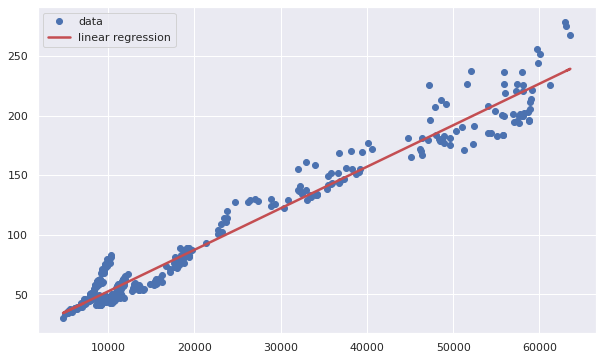

In [19]:
plot_reg_line(X, Y)

Determine the hedge ratio of the 2-asset portfolio using linear regression.

In [20]:
def plot_reg_pair(independent, dependent, showplot=False):

    model = sm.OLS(dependent, independent)
    coeff = model.fit().params

    if len(coeff) == 2:
        hedge_ratio = coeff[1]
        intercept = coeff[0]
    else:
        hedge_ratio = coeff[0]
        intercept = 0

    if showplot:
        fig, ax = plt.subplots(figsize=(10,6))

        ax.plot(independent, dependent, 'bo', label='data')
        ax.plot(independent, independent*hedge_ratio+intercept, 'r', lw=2.5, label='linear regression')
        ax.set_xlabel(X.name)
        ax.set_ylabel(Y.name)

        plt.legend(loc=0)
        plt.show()
    
    return hedge_ratio

In [21]:
hedge_ratio = plot_reg_pair(X, Y)

In [22]:
hedge_ratio

0.004024951159878851

Given that Bitcoin is the independent variable here, the hedge ratio of 0.00402 means one will sell 0.00402 Bitcoin when buying every unit of Litcoin.

In [23]:
portf_2_assets = Y - hedge_ratio * X

By constructing the portfolio as such, below shows how the portfolio price series will look like over the same time period.

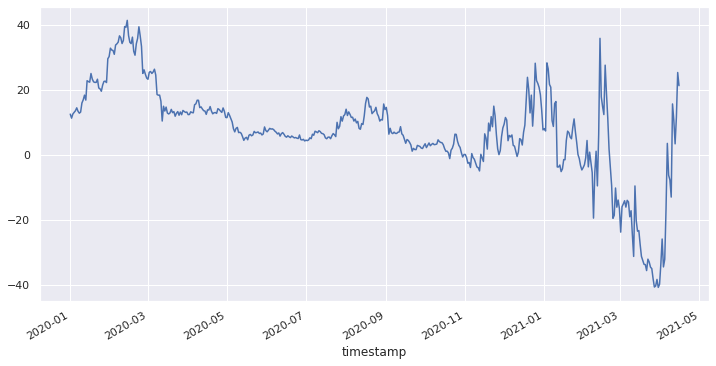

In [24]:
portf_2_assets.plot(figsize=(12,6))
plt.show()

#### Portfolio Analysis
Tests show the portfolio has mean reversion properties

In [25]:
perform_adf_test(portf_2_assets, True)

ADF Statistics: -2.928
p-value: 0.042
Reject null hypothesis. Series is stationary because p-value is less than 0.05.


In [26]:
perform_hurst_exp_test(portf_2_assets, True)

Hurst Exponent: 0.197
Mean Reverting


In [27]:
perform_variance_ratio_test(portf_2_assets, 2, True)

Variance Ratio: 0.372
Random Walk


In [28]:
half_life(portf_2_assets)/PERIOD_PER_DAY

14.95559112404883

In [29]:
perform_coint_test(X, Y, True)

Cointegrated


#### Implementing Trading Strategy

In [30]:
lookback = round(half_life(portf_2_assets))
qty = -(portf_2_assets-portf_2_assets.rolling(lookback).mean())/portf_2_assets.rolling(lookback).std()

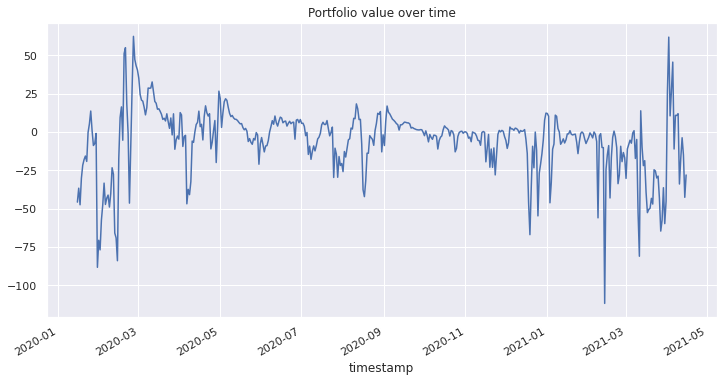

In [31]:
position = portf_2_assets * qty
position.plot(figsize=(12,6), title='Portfolio value over time');

#### Performance Results

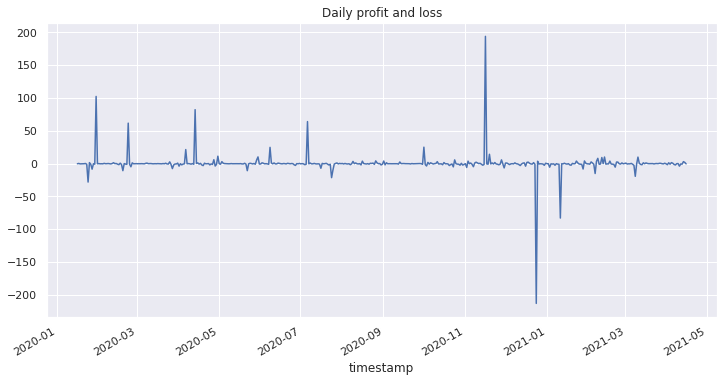

In [32]:
pnl = position.pct_change().dropna()
pnl.plot(figsize=(12,6), title='Daily profit and loss');

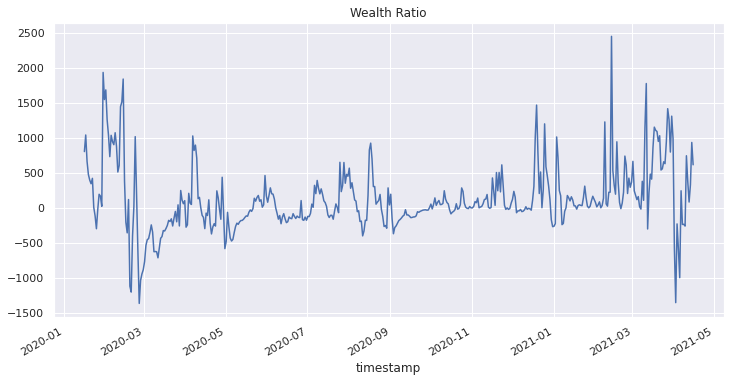

In [33]:
erk.drawdown(pnl).Wealth.plot(figsize=(12,6), title='Wealth Ratio');

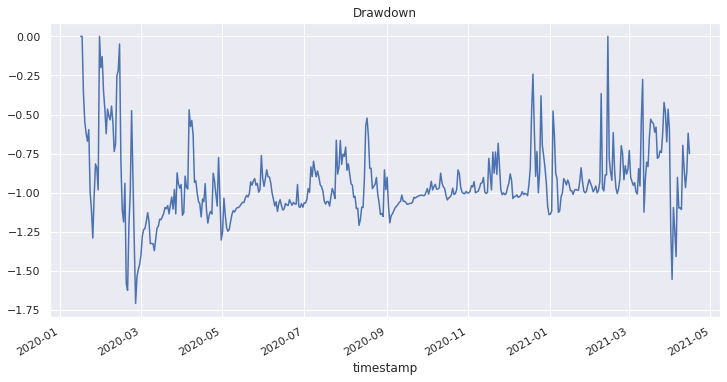

In [34]:
erk.drawdown(pnl).Drawdown.plot(figsize=(12,6), title='Drawdown');

In [35]:
erk.summary_stats(pnl.to_frame(), riskfree_rate=0.02, periods_per_year=PERIOD_PER_YEAR)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
None,-0.237582,258.689657,-0.465925,115.942601,-8.550489,21.355842,-0.000912,-1.708506


Given the negative annualised return and sharpe ratio, the portfolio performance is poor.

### Three Assets

Including all three cryptocurrencies in the portfolio.  Hedge ratios are determined using Johansen eigenvectors.

In [36]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
jres = coint_johansen(prices, det_order=0, k_ar_diff=1)

In [37]:
# jres.ind
# jres.eig
# jres.evec[:,0]

In [38]:
coeff = jres.evec[:,0]

In [39]:
portf_3_assets = (prices * coeff).sum(axis=1)

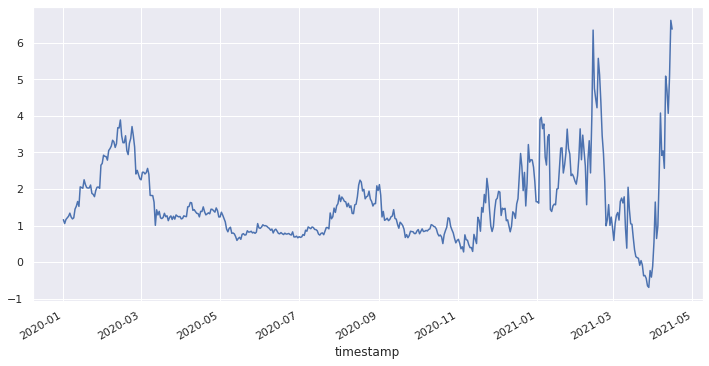

In [40]:
portf_3_assets.plot(figsize=(12,6));

#### Portfolio Analysis
Tests show the portfolio has mean reversion properties

In [41]:
perform_adf_test(portf_3_assets, True)

ADF Statistics: -2.711
p-value: 0.072
Do not reject null hypothesis. Series is not stationary because p-value is greater than 0.05.


In [42]:
perform_hurst_exp_test(portf_3_assets, True)

Hurst Exponent: 0.182
Mean Reverting


In [43]:
perform_variance_ratio_test(portf_3_assets, 2, True)

Variance Ratio: 0.520
Random Walk


In [44]:
half_life(portf_3_assets)/PERIOD_PER_DAY

12.622440816088806

#### Implementing Trading Strategy

In [45]:
lookback = round(half_life(portf_3_assets))
qty = -(portf_3_assets-portf_3_assets.rolling(lookback).mean())/portf_3_assets.rolling(lookback).std()

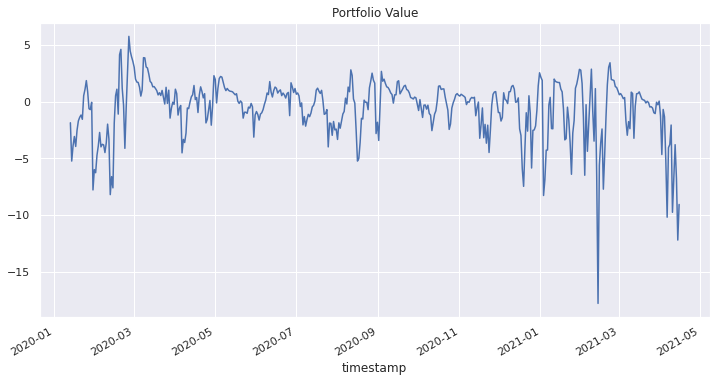

In [46]:
position = portf_3_assets * qty
position.plot(figsize=(12,6), title='Portfolio Value');

#### Performance Results

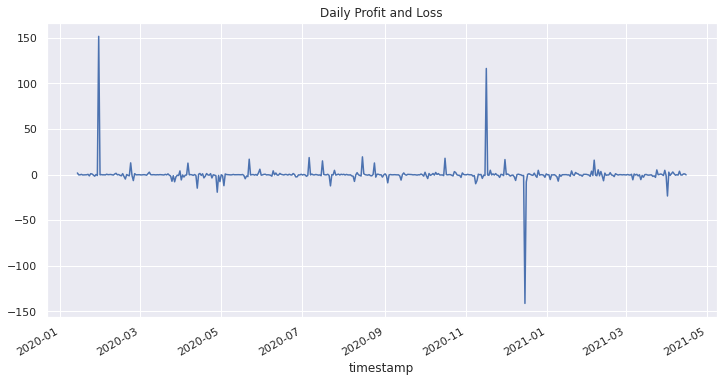

In [47]:
pnl = position.pct_change().dropna()
pnl.plot(figsize=(12,6), title='Daily Profit and Loss');

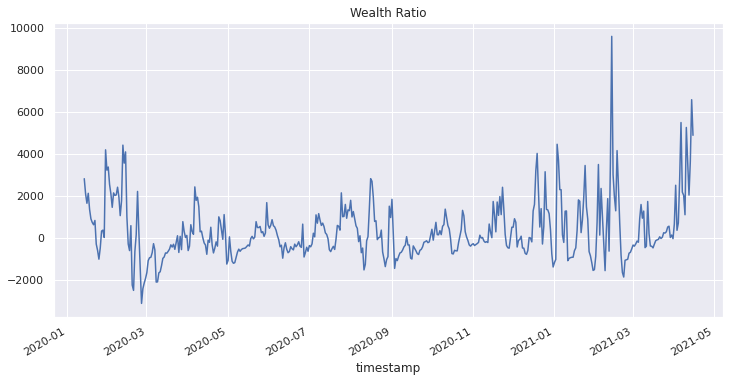

In [48]:
erk.drawdown(pnl).Wealth.plot(figsize=(12,6), title='Wealth Ratio');

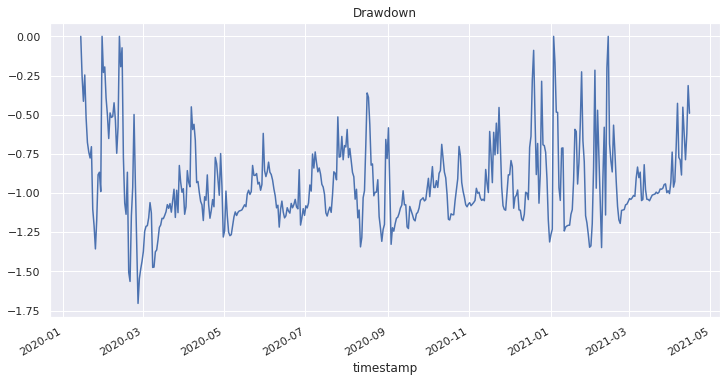

In [49]:
erk.drawdown(pnl).Drawdown.plot(figsize=(12,6), title='Drawdown');

In [50]:
erk.summary_stats(pnl.to_frame(), riskfree_rate=0.02, periods_per_year=PERIOD_PER_YEAR)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
None,1.394318,185.106639,3.108161,131.855421,-23.601416,14.865638,0.0073,-1.703763


Portfolio performance is better with positive annualised return.  However, sharpe ratio is low due to high volatility. 

## Enhancing the Trading Strategy

Data preprocessing to use the backtesting library later.  Using the 3-asset portfolio prices here.

In [51]:
bt_port = portf_3_assets.to_frame()
bt_port.columns = ['Close']
bt_port['Open'] = bt_port['Close']
bt_port['High'] = bt_port['Close']
bt_port['Low'] = bt_port['Close']

### Adjusted Strategy

1. Calculate a Z-Score at time t, normalising the price at t by its rolling mean and standard deviation.
2. Execute a trade if the calculate Z-Score is below or above a threshold.  Buy when Z-Score is below threshold and sell when Z-Score is above threshold.
3. Each trade if executed is transacted with maximum cash on hand.
4. A buying trade is closed when the Z-Score becomes positive and a selling trade is closed when the Z-Score becomes negative.

In [52]:
def Z_Score(values, n):
    """
    Return simple moving average of `values`, at
    each step taking into account `n` previous values.
    """
    series = pd.Series(values)
    return (series - series.rolling(n).mean())/series.rolling(lookback).std()

In [53]:
from backtesting import Strategy
from backtesting.lib import crossover

class Z_Score_Naive(Strategy):
    
    lookback = 30
    threshold = 2
    stoploss = 0.001
    
    def init(self):
        self.ZScore = self.I(Z_Score, self.data.Close, self.lookback)
    
    def next(self):
        if (self.position.is_long) & (self.ZScore > 0):
            self.position.close()
            
        if (self.position.is_short) & (self.ZScore < 0):
            self.position.close()
        
        if self.position.pl_pct < -self.stoploss:
            self.position.close()   

        if (self.ZScore < -self.threshold) & (~self.position.is_long):
            self.position.close()
            self.buy()

        if (self.ZScore > self.threshold) & (~self.position.is_short):
            self.position.close()
            self.sell()

Loading BokehJS ...

In [54]:
from backtesting import Backtest

### Initial Parameters
1. Threshold = -2 and 2
2. Lookback Period = 30 (Depending on price data frequency, 30 days in this analysis)
4. Stoploss = 0.001 (Close position is the percentage loss is greater than this number)

In [55]:
bt = Backtest(bt_port, Z_Score_Naive, cash=10000, commission=.002)
stats = bt.run()
stats

Start                     2020-01-01 08:00...
End                       2021-04-15 08:00...
Duration                    470 days 00:00:00
Exposure Time [%]                   39.278132
Equity Final [$]                   851.522313
Equity Peak [$]                  13337.201174
Return [%]                         -91.484777
Buy & Hold Return [%]              449.790279
Return (Ann.) [%]                  -85.176229
Volatility (Ann.) [%]              272.518395
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.339951
Avg. Drawdown [%]                  -17.561295
Max. Drawdown Duration      403 days 00:00:00
Avg. Drawdown Duration       71 days 00:00:00
# Trades                                   93
Win Rate [%]                        49.462366
Best Trade [%]                     199.173237
Worst Trade [%]                    -73.319011
Avg. Trade [%]                    

In [56]:
bt.plot()

### Observations
The performance of the strategy was poor and it concluded with a -91% return.  We can perform a parameter search to find the optimal parameters that produce better performance.

## Parameter Optimisation

### Parameter Search Grid

1. Threshold = 2, 2.5, 3, 3.5, 4, 4.5
2. Lookback Period = 20, 25, 30, 35
4. Stoploss = 0.001, 0.002, 0.003, 0.004, 0.005

#### Maximising Final Equity
##### Optimal Parameters:
1. Lookback Period = 35
2. Threshold = 2
3. Stoploss = 0.003

##### Portfolio Performance
1. Annualised Return is high but the annualised volatility is much higher and hence the sharpe ratio is zero.
2. There are 47 trades done but only 53% are winners.  The worst performing trade has a negative return of 1587%.

In [57]:
%%time

stats = bt.optimize(lookback = range(20, 40, 5),
                    threshold = np.arange(2, 5.5, 0.5).tolist(),
                    stoploss = np.arange(0.001, 0.005, 0.001).tolist(),
                    maximize='Equity Final [$]')
stats

  0%|          | 0/8 [00:00<?, ?it/s]

CPU times: user 148 ms, sys: 76.6 ms, total: 225 ms
Wall time: 1.94 s


Start                     2020-01-01 08:00...
End                       2021-04-15 08:00...
Duration                    470 days 00:00:00
Exposure Time [%]                   52.229299
Equity Final [$]               1092953.519598
Equity Peak [$]                2091965.854447
Return [%]                       10829.535196
Buy & Hold Return [%]              449.790279
Return (Ann.) [%]                 3700.214459
Volatility (Ann.) [%]     57713302167247.7...
Sharpe Ratio                              0.0
Sortino Ratio                       27.531062
Calmar Ratio                        45.661585
Max. Drawdown [%]                  -81.035611
Avg. Drawdown [%]                   -21.68025
Max. Drawdown Duration      115 days 00:00:00
Avg. Drawdown Duration       14 days 00:00:00
# Trades                                   47
Win Rate [%]                        53.191489
Best Trade [%]                     121.871541
Worst Trade [%]                  -1586.976326
Avg. Trade [%]                    

In [58]:
stats._strategy

<Strategy Z_Score_Naive(lookback=35,threshold=2.0,stoploss=0.003)>

In [59]:
stats['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,-3225,36,38,3.099896,3.335293,-7.591551e+02,-0.075937,2020-02-06 08:00:00+08:00,2020-02-08 08:00:00+08:00,2 days
1,-2813,39,43,3.284921,3.670313,-1.084109e+03,-0.117322,2020-02-09 08:00:00+08:00,2020-02-13 08:00:00+08:00,4 days
2,-2100,44,57,3.883264,2.510916,2.881932e+03,0.353401,2020-02-14 08:00:00+08:00,2020-02-27 08:00:00+08:00,13 days
3,6044,68,70,1.826168,1.642356,-1.110956e+03,-0.100654,2020-03-09 08:00:00+08:00,2020-03-11 08:00:00+08:00,2 days
4,9854,71,97,1.007437,1.519303,5.043920e+03,0.508086,2020-03-12 08:00:00+08:00,2020-04-07 08:00:00+08:00,26 days
5,-10649,119,121,1.405911,1.235815,1.811356e+03,0.120987,2020-04-29 08:00:00+08:00,2020-05-01 08:00:00+08:00,2 days
6,18539,126,128,0.905258,0.922787,3.249826e+02,0.019364,2020-05-06 08:00:00+08:00,2020-05-08 08:00:00+08:00,2 days
7,21436,131,133,0.798083,0.695825,-2.191997e+03,-0.128129,2020-05-11 08:00:00+08:00,2020-05-13 08:00:00+08:00,2 days
8,25099,134,151,0.594266,0.936354,8.586083e+03,0.575649,2020-05-14 08:00:00+08:00,2020-05-31 08:00:00+08:00,17 days
9,31681,176,179,0.741830,0.686949,-1.738670e+03,-0.073980,2020-06-25 08:00:00+08:00,2020-06-28 08:00:00+08:00,3 days


In [60]:
bt.plot(plot_volume=False)

#### Minimising Maximum Drawdown

##### Optimal Parameters:
1. Lookback Period = 25
2. Threshold = 5
3. Stoploss = 0.002

##### Portfolio Performance
1. Annualised Return is low but the annualised volatility is high.
2. Sharpe ratio is at 0.21 is poor
2. There is only 1 trade done.

In [61]:
stats = bt.optimize(lookback = range(20, 40, 5),
                    threshold = np.arange(2, 5.5, 0.5).tolist(),
                    stoploss = np.arange(0.001, 0.005, 0.001).tolist(),
                    maximize = 'Max. Drawdown [%]')
stats

  0%|          | 0/8 [00:00<?, ?it/s]

Start                     2020-01-01 08:00...
End                       2021-04-15 08:00...
Duration                    470 days 00:00:00
Exposure Time [%]                    0.636943
Equity Final [$]                 10276.790037
Equity Peak [$]                  10276.790037
Return [%]                             2.7679
Buy & Hold Return [%]              449.790279
Return (Ann.) [%]                    2.138369
Volatility (Ann.) [%]               10.370607
Sharpe Ratio                         0.206195
Sortino Ratio                        0.395331
Calmar Ratio                         0.338239
Max. Drawdown [%]                   -6.322064
Avg. Drawdown [%]                   -6.322064
Max. Drawdown Duration        3 days 00:00:00
Avg. Drawdown Duration        3 days 00:00:00
# Trades                                    1
Win Rate [%]                            100.0
Best Trade [%]                       2.768025
Worst Trade [%]                      2.768025
Avg. Trade [%]                    

In [62]:
stats._strategy

<Strategy Z_Score_Naive(lookback=25,threshold=5.0,stoploss=0.002)>

In [63]:
bt.plot(plot_volume=False)

#### Minimising Volatility

##### Optimal Parameters:
1. Lookback Period = 25
2. Threshold = 5
3. Stoploss = 0.001

##### Portfolio Performance
1. Annualised Return is negative.
2. There is only 2 trades done.

In [64]:
def neg_Volatility(stats):
    return -stats['Volatility (Ann.) [%]']

In [65]:
stats = bt.optimize(lookback = range(20, 40, 5),
                    threshold = np.arange(2, 5.5, 0.5).tolist(),
                    stoploss = np.arange(0.001, 0.005, 0.001).tolist(),
                    maximize = neg_Volatility)
stats

  0%|          | 0/8 [00:00<?, ?it/s]

Start                     2020-01-01 08:00...
End                       2021-04-15 08:00...
Duration                    470 days 00:00:00
Exposure Time [%]                    0.849257
Equity Final [$]                  9111.550045
Equity Peak [$]                       10000.0
Return [%]                            -8.8845
Buy & Hold Return [%]              449.790279
Return (Ann.) [%]                   -6.956476
Volatility (Ann.) [%]                5.450109
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                     -8.8845
Avg. Drawdown [%]                     -8.8845
Max. Drawdown Duration      386 days 00:00:00
Avg. Drawdown Duration      386 days 00:00:00
# Trades                                    2
Win Rate [%]                              0.0
Best Trade [%]                      -2.735518
Worst Trade [%]                      -6.32235
Avg. Trade [%]                    

In [66]:
stats._strategy

<Strategy Z_Score_Naive(lookback=25,threshold=5.0,stoploss=0.001)>

In [67]:
bt.plot(plot_volume=False)

#### Maximising Sharpe Ratio

##### Optimal Parameters:
1. Lookback Period = 30
2. Threshold = 5
3. Stoploss = 0.001

##### Portfolio Performance
1. Annualised Return at 30% and annualised volatility at 27% with reasonably decent sharpe ratio at 1.1.
2. There is only 7 trades done.  The best trade with a return of 17% and the worst trade with a return of -5%.

In [68]:
stats = bt.optimize(lookback = range(20, 40, 5),
                    threshold = np.arange(2, 5.5, 0.5).tolist(),
                    stoploss = np.arange(0.001, 0.005, 0.001).tolist(),
                    maximize = 'Sharpe Ratio')
stats

  0%|          | 0/8 [00:00<?, ?it/s]

Start                     2020-01-01 08:00...
End                       2021-04-15 08:00...
Duration                    470 days 00:00:00
Exposure Time [%]                    2.972399
Equity Final [$]                 13970.995231
Equity Peak [$]                  13970.995231
Return [%]                          39.709952
Buy & Hold Return [%]              449.790279
Return (Ann.) [%]                   29.581643
Volatility (Ann.) [%]               26.797723
Sharpe Ratio                         1.103886
Sortino Ratio                        6.067841
Calmar Ratio                         4.041395
Max. Drawdown [%]                   -7.319662
Avg. Drawdown [%]                   -1.979606
Max. Drawdown Duration       93 days 00:00:00
Avg. Drawdown Duration       25 days 00:00:00
# Trades                                    7
Win Rate [%]                        71.428571
Best Trade [%]                       17.46052
Worst Trade [%]                     -5.469192
Avg. Trade [%]                    

In [69]:
stats._strategy

<Strategy Z_Score_Naive(lookback=30,threshold=5.0,stoploss=0.001)>

In [70]:
bt.plot(plot_volume=False)

## Closing Remarks

1. Portfolio is constructed with a basket of cryptocurrencies.  Their weights (hedge ratios) are determined based on price data from Jan 2020 till the latest available date.
2. Note that the same "in-sample" data is used in backtesting and trading strategy performance measurements.
3. Further analysis to be done to assess how the trading strategies perform on "out-of-sample" data.